In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
from cortex import CortexDataset

[2019-12-10 18:00:43,780] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


In [3]:
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

/u/davidm/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [4]:
%aimport scVI_vae

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection._split import _validate_shuffle_split


In [6]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

###### Split dataset function

In [7]:
"""
def data_loader(dataset):
    np.random.seed(seed=0)
    val_idx = []
    labels = np.unique(dataset.labels)
    for i in range(len(labels)) : 
        idx = np.argwhere(dataset.labels == i).T[0]
        val_idx.append(np.random.choice(idx, 100))
    val_idx = np.array(val_idx).ravel()
    x_train = np.delete(dataset.X, val_idx, axis=0)
    x_train = np.log(x_train + 1)
    y_train = np.delete(dataset.labels, val_idx, axis=0)
    x_val = np.log(dataset.X[val_idx, :] + 1)
    y_val = dataset.labels[val_idx, :]
    return x_train, y_train, x_val,y_val
"""

'\ndef data_loader(dataset):\n    np.random.seed(seed=0)\n    val_idx = []\n    labels = np.unique(dataset.labels)\n    for i in range(len(labels)) : \n        idx = np.argwhere(dataset.labels == i).T[0]\n        val_idx.append(np.random.choice(idx, 100))\n    val_idx = np.array(val_idx).ravel()\n    x_train = np.delete(dataset.X, val_idx, axis=0)\n    x_train = np.log(x_train + 1)\n    y_train = np.delete(dataset.labels, val_idx, axis=0)\n    x_val = np.log(dataset.X[val_idx, :] + 1)\n    y_val = dataset.labels[val_idx, :]\n    return x_train, y_train, x_val,y_val\n'

In [8]:
# paper's implementation 
def train_test_validation(
        gene_dataset=None,
        train_size=0.9, # same train size as in the paper
        test_size=None,
    ):
        """Creates posteriors ``train_set``, ``test_set``, ``validation_set``.
            If ``train_size + test_size < 1`` then ``validation_set`` is non-empty.
            :param train_size: float, int, or None (default is 0.1)
            :param test_size: float, int, or None (default is None)
            """
        gene_dataset = (
            self.gene_dataset
            if gene_dataset is None and hasattr(self, "model")
            else gene_dataset
        )
        n = len(gene_dataset)
        try:
            n_train, n_test = _validate_shuffle_split(n, test_size, train_size)
        except ValueError:
            if train_size != 1.0:
                raise ValueError(
                    "Choice of train_size={} and test_size={} not understood".format(
                        train_size, test_size
                    )
                )
            n_train, n_test = n, 0
        random_state = np.random.RandomState(seed=0) # same seed as in the paper
        permutation = random_state.permutation(n)
        indices_test = permutation[:n_test]
        indices_train = permutation[n_test : (n_test + n_train)]
        indices_validation = permutation[(n_test + n_train) :]
        return indices_train, indices_test, indices_validation

###### Plot function

In [9]:
def plot_latent(X, y, labels):
    #labels = np.unique(y)
    palette = cm.get_cmap('viridis', 6)
    fig, ax = plt.subplots()
    for i in range(len(labels)) :
        color = palette(i / len(labels))
        scatter = ax.scatter(x = X[np.argwhere(y == i)].T[0], y = X[np.argwhere(y== i)].T[1], c = color, label = labels[i], s=10, alpha=0.8)
    ax.legend()
    ax.grid()
    plt.tight_layout()

In [28]:
# paper's implementation

def apply_t_sne(latent, n_samples=1000):
    idx_t_sne = (
        np.random.permutation(len(latent))[:n_samples]
        if n_samples
        else np.arange(len(latent))
    )
    if latent.shape[1] != 2:
        latent = TSNE().fit_transform(latent[idx_t_sne])
    return latent, idx_t_sne

## Load Cortex dataset

In [11]:
cortex_dataset = CortexDataset(save_path="./data/", total_genes=558)

[2019-12-10 18:00:48,453] INFO - scvi.dataset.dataset | File /u/davidm/Documents/Cours/IFT6269/project/umontreal-ift6269-pgm/data/expression.bin already downloaded
[2019-12-10 18:00:55,641] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-10 18:00:55,642] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


#### No batch annotation :

In [12]:
np.unique(cortex_dataset.batch_indices)

array([0], dtype=uint16)

#### 7 neuronal cells lines in Cortex :

In [13]:
labels = np.unique(cortex_dataset.labels)

In [14]:
labels

array([0, 1, 2, 3, 4, 5, 6], dtype=uint16)

#### Split dataset 

In [15]:
#x_train, y_train, x_val,y_val = data_loader(cortex_dataset)
idx_train, idx_test, _ = train_test_validation(cortex_dataset)
x_train = cortex_dataset.X[idx_train]
x_train = np.log(x_train + 1)
y_train = cortex_dataset.labels[idx_train]
x_test = cortex_dataset.X[idx_test]
x_test = np.log(x_test + 1)
y_test = cortex_dataset.labels[idx_test]

### PCA on raw data

In [16]:
pca = PCA(2)

In [17]:
x = pca.fit_transform(x_train)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

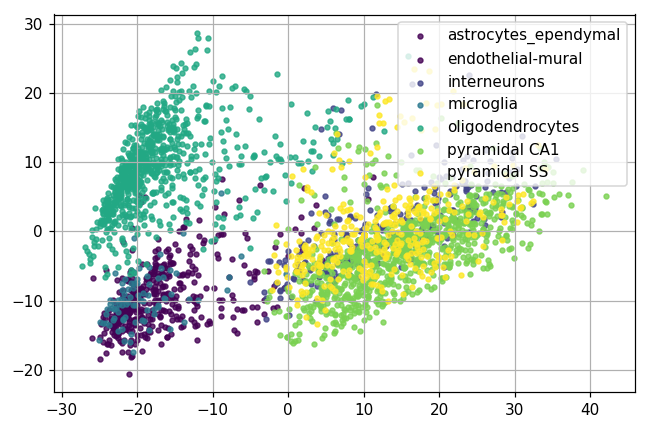

In [18]:
plot_latent(x, y_train, cortex_dataset.cell_types)

### Training our scVI reimplementation

In [19]:
vae = scVI_vae.scVI_vae(n_genes = cortex_dataset.nb_genes)

In [20]:
losses_train, losses_test = scVI_vae.train_scvi(vae, x_train, x_test, n_epochs=250)

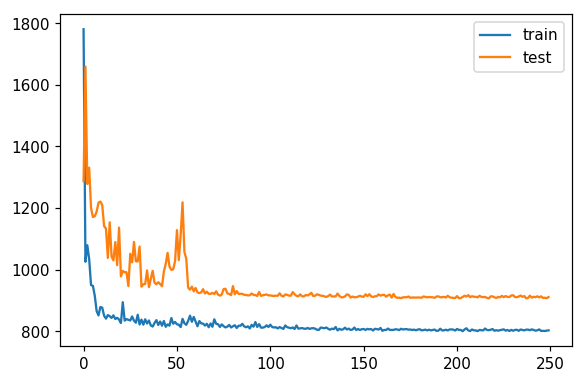

In [21]:
plt.plot(losses_train, label="train")
plt.plot(losses_test, label = "test")
plt.legend()

In [22]:
latent_space = vae.infere_z_posterior(x_train)

In [23]:
latent_space.size()

torch.Size([2704, 10])

### PCA on our scVI reimplementation

In [24]:
pca = PCA(2)

In [25]:
x = pca.fit_transform(latent_space.cpu())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

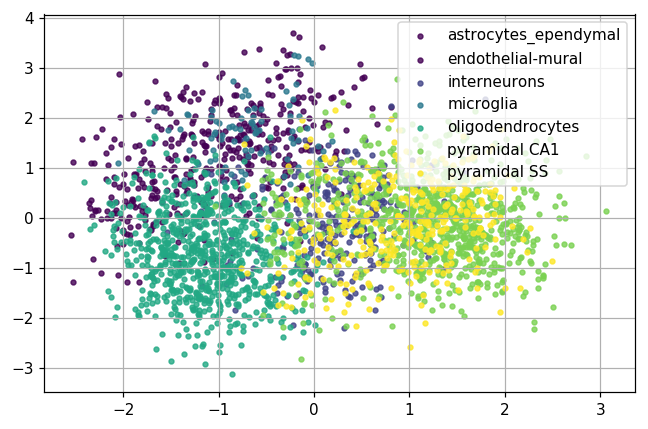

In [26]:
plot_latent(x, y_train, labels = cortex_dataset.cell_types)

### TSNE on our scVI reimplementation

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

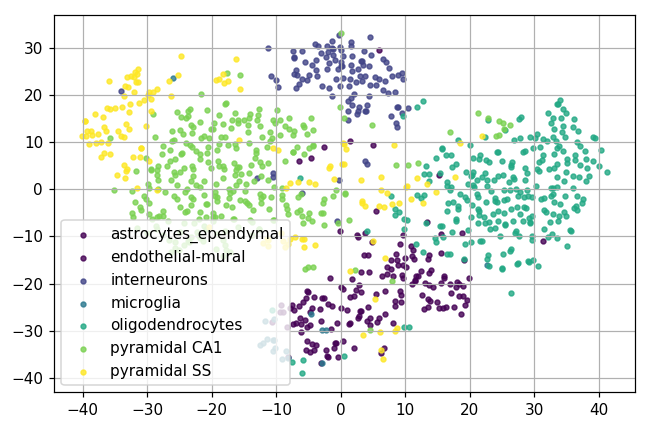

In [29]:
#tsne = TSNE(2)
#x = tsne.fit_transform(latent_space.cpu())
#plot_latent(x, y_train)
x, idx = apply_t_sne(latent_space.cpu())
y = y_train[idx].ravel()
plot_latent(x, y, cortex_dataset.cell_types)

In [ ]:
torch.__version__

### Training scVI (paper's implementation)

In [30]:
# set hyperparameters 
n_epochs = 250
lr = 0.001
use_batches = False
use_cuda = True##### PCA on scVI paper's implementation

In [31]:
cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(
    cortex_vae,
    cortex_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=1,
)

In [32]:
trainer_cortex.train(n_epochs=n_epochs)

training: 100%|██████████| 250/250 [00:58<00:00,  4.65it/s]


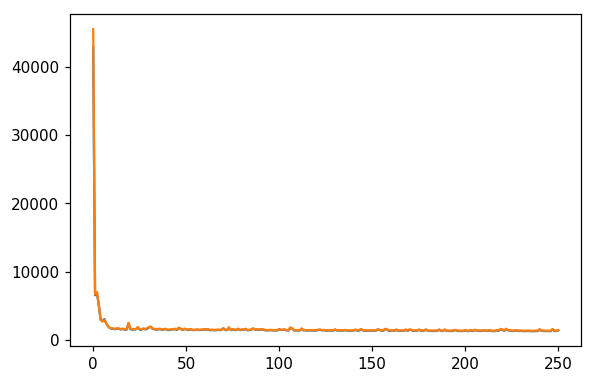

In [33]:
elbo_train_set = trainer_cortex.history["elbo_train_set"]
elbo_test_set = trainer_cortex.history["elbo_test_set"]
plt.plot(elbo_train_set)
plt.plot(elbo_test_set)

In [34]:
lat = cortex_vae.sample_from_posterior_z(torch.tensor(x_train).to("cuda"))

In [35]:
lat.size()

torch.Size([2704, 10])

### PCA on scVI paper's implementation

In [36]:
x = pca.fit_transform(lat.detach().cpu().numpy())

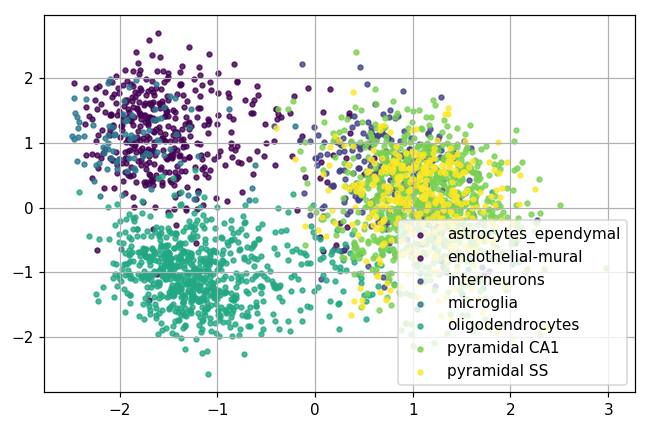

In [37]:
plot_latent(x, y_train, labels = cortex_dataset.cell_types)

### TSNE on scVI paper's implementation

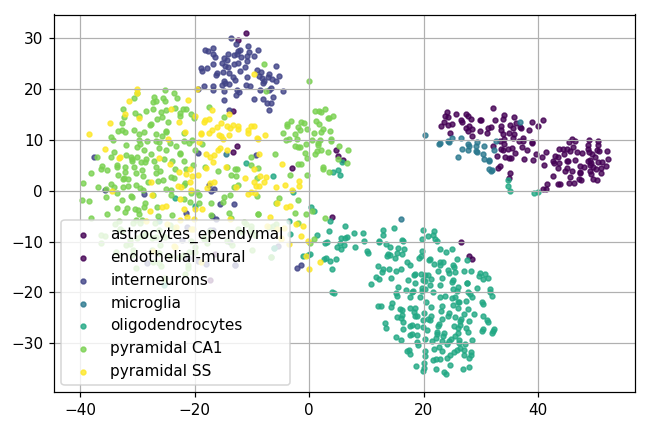

In [38]:
#tsne = TSNE(2)
#x = tsne.fit_transform(lat.detach().cpu().numpy())
x, idx = apply_t_sne(lat.detach().cpu().numpy())
y = y_train[idx].ravel()
plot_latent(x, y, cortex_dataset.cell_types)

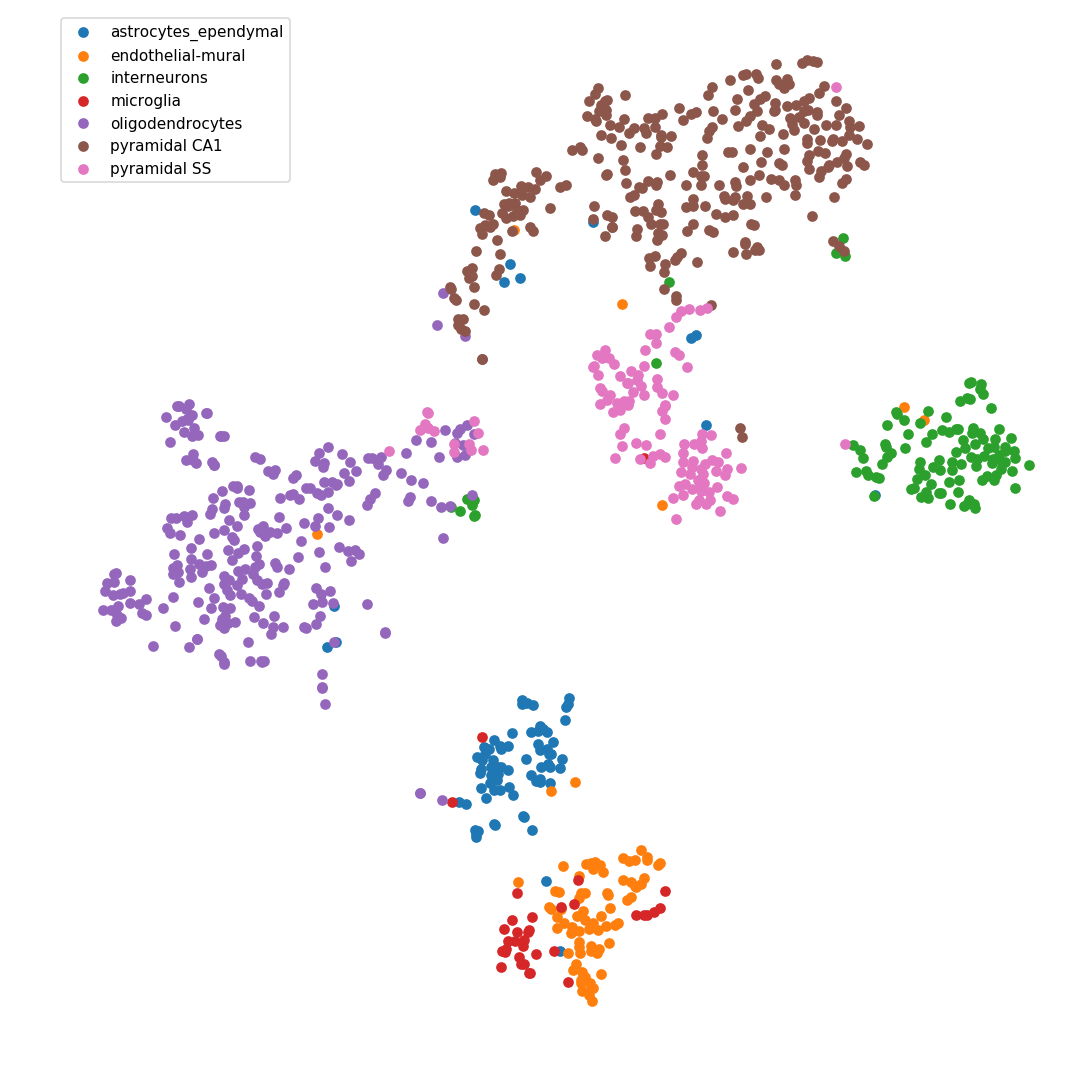

In [39]:
n_samples_tsne = 1000
trainer_cortex.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')